In [1]:
import numpy as np
import pylab as plt
%matplotlib inline

class TuningFunction(object):
    INPUT = "INPUT"
    CENTER = "CENTER"    
    def __init__(self, func, center=0, data=None, center_name=None, **func_kwargs):
        '''
        func: the function that is being used to represent the curve.
        center: the mean/offset of the curve
        data: the inputs for func that the user must repeatedly 
                provide for every sample: only meant to be used within copy_to()
                It will prevent the use of the INPUT checker in func_kwargs below
        func_kwargs: the inputs for func that are constant
            You can specify which arguments must go into data by 
            assigning the constant value "INPUT":
                import scipy.stats as st
                tf = TuningFunction(st.norm.pdf, x = INPUT, loc = 0, scale = 1)
                tf.sample(x=1)
            You can make one value equal the assigned center value with CENTER
        '''
        self.func = func
        self.center = center
        self.func_kwargs = func_kwargs.copy()
        if center_name:
            self.center_name = center_name
        else:
            self.center_name = [f for f in func_kwargs if func_kwargs[f] == TuningFunction.CENTER]
            if len(self.center_name) > 1:
                raise Exception("Multiple center values given: {0}".format(self.center_name))
            elif len(self.center_name) == 1:
                self.center_name = self.center_name[0]
                del self.func_kwargs[self.center_name]
            else:
                self.center_name = None
            
        if not data:
            self.data = [f for f in func_kwargs if func_kwargs[f] == TuningFunction.INPUT]
            for k in self.data:
                del self.func_kwargs[k]
        else:
            self.data = data

    def copy_to(self, center):
        '''Make a duplicate tuning function with a different center/mean point'''
        return TuningFunction(self.func, center, self.data, self.center_name, **self.func_kwargs)
    
    def sample(self, point=None, **kwargs):
        '''Sample a value from the tuning function.
            point only works if there is a single nonconstant value to specify
            and kwargs is empty.
        '''
        relevant = {}
        
        if len(kwargs.keys()) == 0 and self.data and len(self.data)==1 and point is not None:
            kwargs[self.data[0]] = point
                
        for k in self.data:
            if not k in kwargs:
                raise Exception("Missing sample argument: {0}".format(k))
            relevant[k] = kwargs[k]
        if self.center_name:
            relevant[self.center_name] = self.center
        for key in self.func_kwargs:
            relevant[key] = self.func_kwargs[key]
        out = self.func(**relevant)

        return out
    
class GaussianNoise(TuningFunction):
    def __init__(self, scale=1, center=0):
        super(GaussianNoise, self).__init__(np.random.normal, center, loc = GaussianNoise.CENTER, scale = scale)
        
        
class Model(object):
    def __init__(self, nchannels, domain, noise, tuning_function):
        '''
        Create a series of tuning functions given: 
            the number of channels (integer), 
            the range of the inputs (list-like with 2 values: [-1,1], 
            the noise function (an instance of TuningFunction), 
            and the tuning function (an instance of TuningFunction)
        '''
        self.nchannels = nchannels
        self.domain = domain
        self.noise = noise
        self.tuning_function = tuning_function
        self.channels = []
        w = (domain[-1]-domain[0])/float(self.nchannels)
        for i in np.arange(domain[0], domain[-1], w):
            self.channels.append(tuning_function.copy_to(i+w/2.))
        if len(self.channels) != self.nchannels:
            raise Exception("Generated channel count does not match requested number of channels.")
            
    def sample(self, point=None, **kwargs):
        '''
        Samples values for all channels given common key word arguments and adds noise
        Presumably, one of the keyword arguments will dictate the position, however,
        it also allows for lazy people to put pass a single value instead of a keyword argument 
        if there is only one value to pass.
        
        The output is the array of activities for each channel with noise.
        '''
        responses = np.zeros((len(self.channels),))
        noises = np.zeros((len(self.channels),))
        for i, c in enumerate(self.channels):
            responses[i] = c.sample(point=point, **kwargs)
            noises[i] = self.noise.sample(point=point, **kwargs)
        return responses+noises
    
    def likelihood(self, sample):
        '''
        Given a sample (of stimuli?) as input, 
        return the [log?] likelihood that it came from this model?
        '''
        L = None
        
        return L
    
    @staticmethod
    def aic(sample, *models):
        '''
        Given a sample and several models as input, find the model with the 
        best Akaike Information Criterion value and 
        return the model and the AIC score.
        '''
        winning_index = None
        best_AIC = None
        
        return models[winning_index], best_AIC
    
    @staticmethod
    def bic(sample, *models):
        '''
        Given a sample and several models as input, find the model with the 
        best Bayesian Information Criterion value and 
        return the model and the BIC score.
        '''
        winning_index = None
        best_BIC = None
        
        return models[winning_index], best_BIC
    
    def thresholds(self):
        '''
        Get the threshold of discrimination (d') for the model.
        '''
        pass
    
    def plot_channels(self, samples_per_channel):
        '''
        Given the number of samples for every channel (across the domain), 
        plot the channels with noise
        '''
        lines = []
        w = (self.domain[-1]-self.domain[0])/float(samples_per_channel)
        xs = np.arange(self.domain[0], self.domain[-1], w)
        for c in self.channels:
            line = []
            for i in xs:
                line.append(c.sample(i)+self.noise.sample(i))
            plt.plot(xs, line)
        
        plt.show()

1.92364965668e-22
-0.023243902847592722
[-0.05624587  0.01834423 -0.07005351  0.00211489  0.86475555  0.00401231
 -0.00398703  0.01930835 -0.04240768]
[-0.08474649  0.03483283 -0.00402678  0.01685254  0.00172828 -0.01431272
  0.07635565  0.2165187   0.92761527]
[ 0.02600972 -0.13760349  0.02150153  0.13015518  0.99541917  0.10300729
 -0.07848576  0.00252915  0.05432498]
[ 0.00660106  0.04564842  0.07606366  0.03892651  0.00404613  0.04742979
  0.03783341  0.16410647  0.9230873 ]


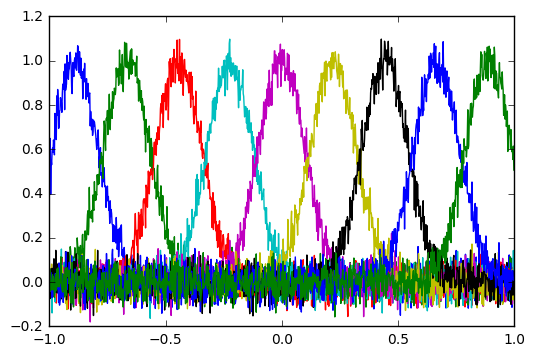

In [2]:
import scipy.stats as st
def func(x, loc, scale):
    return st.norm.pdf(x,loc,scale)/4

tf = TuningFunction(func, x = TuningFunction.INPUT, loc = TuningFunction.CENTER, scale = .1)
import numpy as np
nf = GaussianNoise(scale=.05)
model = Model(9, [-1,1], nf, tf)

print (tf.sample(x=1))
print (nf.sample())

print (model.sample(x=0))
print (model.sample(x=.85))

print (model.sample(0))
print (model.sample(.85))

model.plot_channels(1000)